In [1]:
import pandas as pd
from scipy.io import mmread
import scanpy as sc
import os
import sys
sys.path.append(os.path.abspath('../../'))
import ScATACAnnotater.SortedNoDupeBedOverlap as bdO
from ScATACAnnotater import io_utils
from ScATACAnnotater import stats_utils

/hpc/users/leeh36/miniconda3/lib/python3.8/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
mat = mmread('filtered_peak_bc_matrix/matrix.mtx')

In [3]:
mat = mat.T.toarray()

In [4]:
mat.shape

(4654, 84626)

In [5]:
id2bc = pd.read_csv('filtered_peak_bc_matrix/barcodes.tsv', header = None)[0].values
id2peak = io_utils.read_bed_file('filtered_peak_bc_matrix/peaks.bed', '\t')

In [6]:
df_peak = pd.read_csv('filtered_peak_bc_matrix/peaks.bed', header = None, sep = '\t')

In [7]:
len(id2peak), df_peak.shape

(84626, (84626, 3))

In [8]:
id2peak[:4]

[('chr1', 237588, 237918),
 ('chr1', 565103, 565551),
 ('chr1', 569173, 569644),
 ('chr1', 713478, 714827)]

In [9]:
ref_subtype_peaks0, ref_bk_peak = io_utils.read_reference_data('../../data/GSE129785/', verbose = False)
#ref_subtype_peaks0, ref_bk_peak = io_utils.read_reference_data('../../data/cistopic/', verbose = False)

In [10]:
intersect = set(bdO.BedOverlap(id2peak, sorted(ref_bk_peak), 50))

In [11]:
ref_subtype_peaks = []
for c, peaks in ref_subtype_peaks0:
    ref_subtype_peaks.append( (c, set(bdO.BedOverlap(id2peak, sorted(peaks), 50))) )

In [12]:
for c, peaks in ref_subtype_peaks:
    print(c, len(peaks))

Basophil 130
CLP 189
CMP_BMP 169
Central memory CD8 T 229
Effector memory CD8 T 15
GMP 338
Gamma delta T 66
HSC_MPP 134
Immature NK 65
LMPP 152
MDP 344
MEP 231
Mature NK1 207
Mature NK2 11
Memory B 213
Memory CD4 T 70
Monocyte 1 472
Monocyte 2 278
Naive B 180
Naive CD4 T1 68
Naive CD4 T2 294
Naive CD8 T1 11
Naive CD8 T2 8
Naive CD8 T3 47
Naive Treg 3
Plasma cell 311
Pre-B 299
Pro-B 166
Treg 25
cDC 1495
pDC 323


In [13]:
scores = stats_utils.compute_enrichment_score(mat, intersect, id2peak, ref_subtype_peaks, num_cores = 10)

In [14]:
scores

[[3.9720033373505146,
  1.5094809322033897,
  3.183683149531602,
  0.6699960443037974,
  2.150735294117647,
  4.172541293912685,
  0.9402931125131441,
  2.711028256779383,
  0.9552517817502044,
  3.083560988408884,
  4.9574256174697675,
  1.9555463945858669,
  0.5912575851168199,
  0,
  1.6462077736436065,
  0.4355437827304835,
  7.957417935081606,
  10.8511738827424,
  1.58942908117752,
  0.9117356530605742,
  0.5181186398610077,
  3.011449579831933,
  0,
  0.6538408841797588,
  15.061449579831933,
  1.5333984037342245,
  0.8258477426862306,
  0.934232250963126,
  1.254157913165266,
  4.201478941163862,
  1.8987553533190578],
 [1.6319679189748468,
  2.036562162455314,
  2.96754836162653,
  0.7908109989557953,
  0,
  4.103122943026403,
  0,
  1.770616292205347,
  0.6941897150713856,
  2.4121806569343067,
  5.52693470054916,
  2.090958089396896,
  0.6515753273971493,
  2.1891035548686246,
  1.193227383486012,
  0.316600586878122,
  8.21771332333513,
  10.062451582146474,
  1.28940260929

/hpc/users/leeh36/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
... storing 0 as categorical


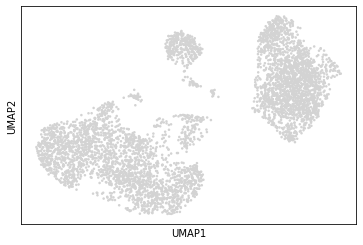

In [15]:
data_obj = sc.AnnData(mat, 
          obs = pd.DataFrame([], index = id2bc),
          var = df_peak,
          )

sc.pp.normalize_total(data_obj)
sc.pp.pca(data_obj, n_comps=50)
sc.pp.neighbors(data_obj)
sc.tl.umap(data_obj)

sc.pl.umap(data_obj)

In [16]:
score_df = pd.DataFrame(scores, 
                        columns = [c for c, _ in ref_subtype_peaks],
                       index = data_obj.obs.index
                       )

In [17]:
score_df.head()

,Basophil,CLP,CMP_BMP,Central memory CD8 T,Effector memory CD8 T,GMP,Gamma delta T,HSC_MPP,Immature NK,LMPP,...,Naive CD8 T1,Naive CD8 T2,Naive CD8 T3,Naive Treg,Plasma cell,Pre-B,Pro-B,Treg,cDC,pDC
AAACGAAAGCGCAATG-1,3.972003,1.509481,3.183683,0.669996,2.150735,4.172541,0.940293,2.711028,0.955252,3.083561,...,3.011450,0.000000,0.653841,15.061450,1.533398,0.825848,0.934232,1.254158,4.201479,1.898755
AAACGAAAGGGTATCG-1,1.631968,2.036562,2.967548,0.790811,0.000000,4.103123,0.000000,1.770616,0.694190,2.412181,...,2.189104,0.000000,0.972484,0.000000,1.594183,1.750661,1.557642,0.000000,4.481621,1.770686
AAACGAAAGTAACATG-1,0.501736,0.694470,0.580202,7.999083,8.069382,0.678074,4.470056,0.486464,2.115326,0.427819,...,12.105758,10.749345,6.652180,16.108184,4.634269,1.114869,0.793706,12.606408,0.808781,1.245063
AAACGAAAGTTACACC-1,1.780043,2.321254,1.349670,8.429496,15.666485,1.352369,14.863852,1.209421,8.674147,1.508806,...,3.119674,4.457143,4.585366,0.000000,3.149680,1.422958,0.378818,7.830513,0.737333,2.081149
AAACGAACAGAGATGC-1,2.976183,2.001946,2.553661,0.595626,0.000000,4.035078,0.692021,2.120396,0.000000,2.185904,...,0.000000,0.000000,0.000000,0.000000,1.190817,1.240442,1.112114,0.000000,5.171614,2.220593


In [18]:
data_obj.obs = score_df

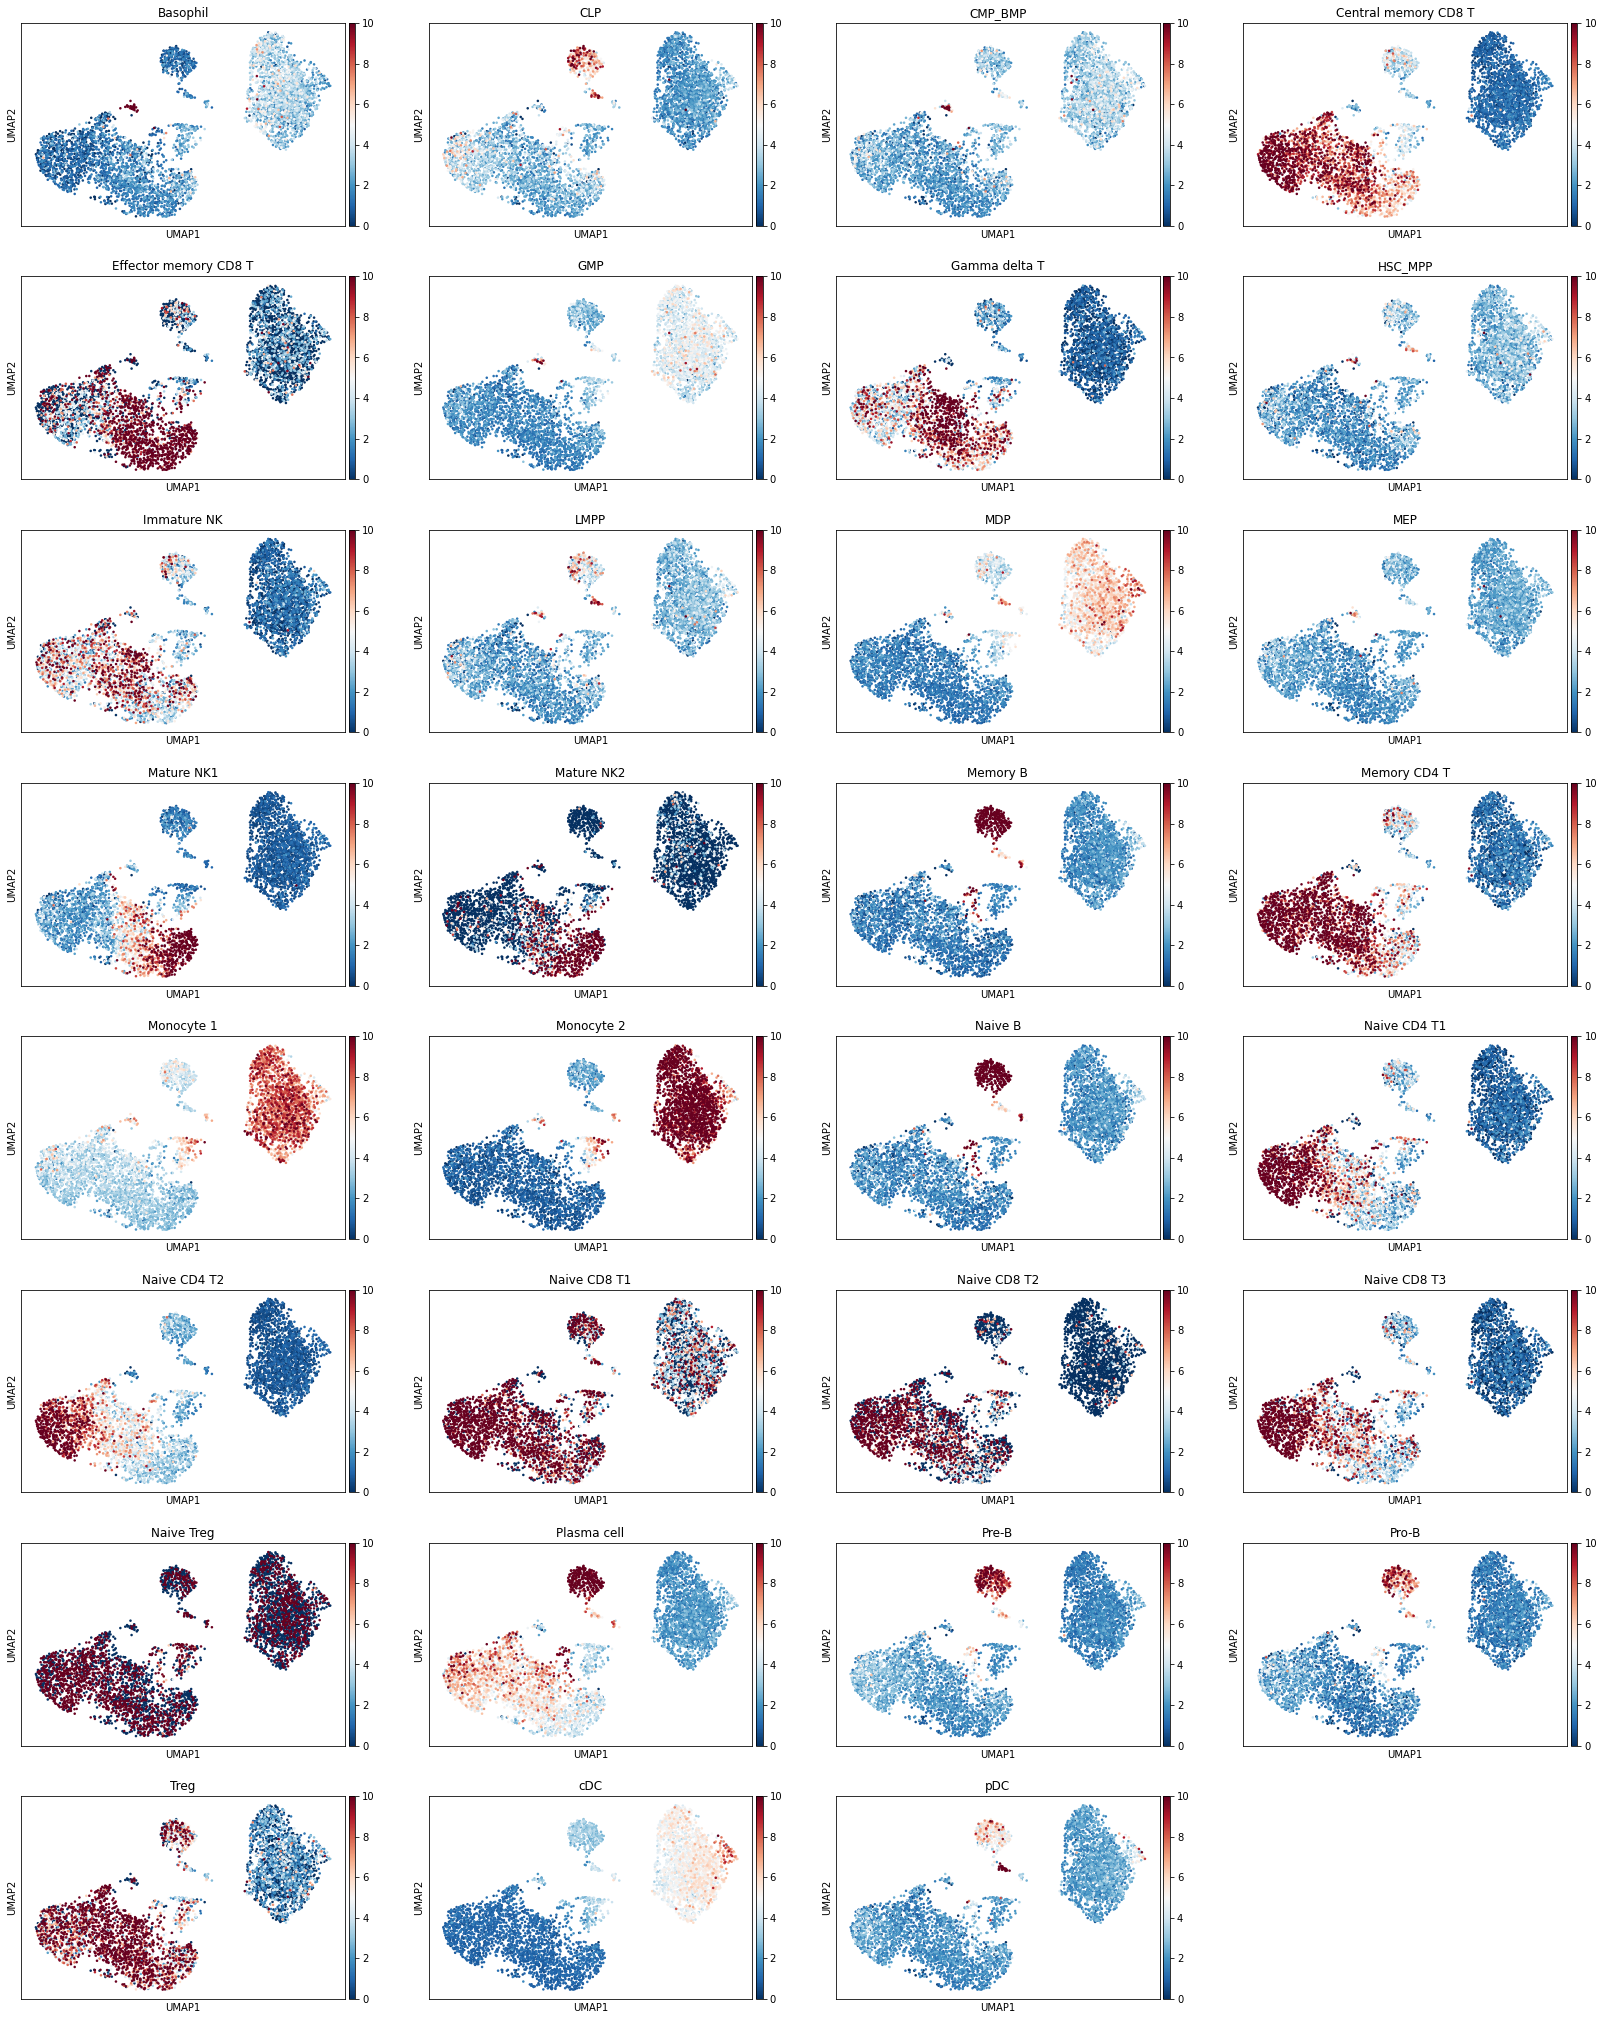

In [21]:
sc.pl.umap(data_obj, color = score_df.columns, cmap = 'RdBu_r', vmax = 10)